In [77]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [78]:
IMG_SIZE = 28
IMG_PATH = 'digit-recognizer/'

BATCH_SIZE = 64

TRAIN_PATH = os.path.join(IMG_PATH+'/train.csv')        # path to train dataset
TEST_PATH = os.path.join(IMG_PATH+'/test.csv')         # path to test dataset

In [79]:
tf.config.list_physical_devices('GPU')

[]

In [80]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

X = df_train.drop(labels=['label'],axis=1)
Y = df_train['label']

X = X.values.reshape(-1,28,28,1)
Y = tf.keras.utils.to_categorical(Y, num_classes=10)

In [81]:

df_test = df_test.values.reshape(-1,28,28,1)
df_test = df_test / 255

In [82]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)


In [83]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range = 0.2,
                             zoom_range = 0.1,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1)

X_train_generated = datagen.fit(X_train)

In [84]:
def CNN():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    # First Conv2d layer
    lz = layers.Conv2D(filters=32, kernel_size=5, padding='same')(inputs)
    lz = layers.Activation('relu')(lz)
    lz = layers.Conv2D(filters=32, kernel_size=5, padding='same')(inputs)
    lz = layers.Activation('relu')(lz)
    lz = layers.MaxPool2D(pool_size=2)(lz)
    lz = layers.Dropout(0.25)(lz)

    # Second Conv2d layer
    lz = layers.Conv2D(filters=64, kernel_size=3, padding='same')(inputs)
    lz = layers.Activation('relu')(lz)
    lz = layers.Conv2D(filters=64, kernel_size=3, padding='same')(inputs)
    lz = layers.Activation('relu')(lz)
    lz = layers.MaxPool2D(pool_size=2, strides=2)(lz)
    lz = layers.Dropout(0.25)(lz)
    
    lz = layers.Flatten()(lz)
    lz = layers.Dense(256, activation='relu')(lz)
    lz = layers.Activation('relu')(lz)
    lz = layers.Dropout(0.25)(lz)
    output = layers.Dense(10, activation='softmax')(lz)   # use loss as binary_crossentropy
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model
    

In [85]:
keras.backend.clear_session()

model = CNN()
model.compile(loss='categorical_crossentropy', 
              optimizer = keras.optimizers.Adam(learning_rate=1e-04), 
              metrics='categorical_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 activation_3 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                             

In [86]:
history = model.fit(X_train, y_train,
          batch_size = BATCH_SIZE, epochs = 10,
          validation_data=(X_val, y_val),
          steps_per_epoch=(len(X_train)/BATCH_SIZE),
          validation_steps=(len(X_val)/BATCH_SIZE))

Epoch 1/10
525/525 [==============================] - 26s 49ms/step - loss: 1.3599 - categorical_accuracy: 0.8087 - val_loss: 0.2291 - val_categorical_accuracy: 0.9364
Epoch 2/10
525/525 [==============================] - 22s 42ms/step - loss: 0.3623 - categorical_accuracy: 0.9039 - val_loss: 0.1580 - val_categorical_accuracy: 0.9575
Epoch 3/10
525/525 [==============================] - 22s 41ms/step - loss: 0.2373 - categorical_accuracy: 0.9341 - val_loss: 0.1195 - val_categorical_accuracy: 0.9642
Epoch 4/10
525/525 [==============================] - 22s 42ms/step - loss: 0.1693 - categorical_accuracy: 0.9524 - val_loss: 0.1153 - val_categorical_accuracy: 0.9677
Epoch 5/10
525/525 [==============================] - 21s 41ms/step - loss: 0.1326 - categorical_accuracy: 0.9597 - val_loss: 0.0902 - val_categorical_accuracy: 0.9765
Epoch 6/10
525/525 [==============================] - 22s 41ms/step - loss: 0.0977 - categorical_accuracy: 0.9717 - val_loss: 0.0945 - val_categorical_accuracy:

[2 0 9 ... 3 9 2]


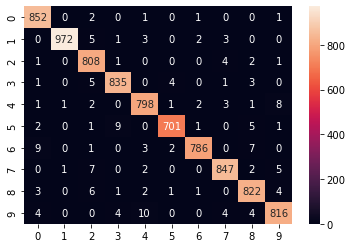

In [87]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis = 1)

from sklearn import metrics
sns.heatmap(metrics.confusion_matrix(np.argmax(y_val, axis = 1), y_pred), annot=True, fmt='g')

output = model.predict(df_test)
results = np.argmax(output, axis = 1)
print(results)
results = pd.Series(results,name="Label")


submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission.csv",index=False)
